<a href="https://www.kaggle.com/code/stiwarids/autismprediction-eda?scriptVersionId=98082918" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Setup

In [1]:
import gc
gc.enable()

import os
import numpy as np
import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
train = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/train.csv')
test = pd.read_csv('../input/autismdiagnosis/Autism_Prediction/test.csv')

# Data overview

In [3]:
train.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,1,38.1727,f,?,no,no,Austria,no,6.3512,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,0,47.7505,m,?,no,no,India,no,2.2552,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,1,7.3804,m,White-European,no,yes,United States,no,14.8515,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,0,23.5619,f,?,no,no,United States,no,2.2766,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,0,43.2058,m,?,no,no,South Africa,no,-4.7773,18 and more,Self,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

### Missing values

In [5]:
train.isna().any().any(), test.isna().any().any()

(False, False)

No missing values on the surface, but we saw there are some '?' in the first few rows which are probably missing data.

### Target class balance

In [6]:
TARGET = 'Class/ASD'

In [7]:
train[TARGET].value_counts(normalize=True)

0    0.7987
1    0.2013
Name: Class/ASD, dtype: float64

Imbalanced, but not extreme. May or may not benefit from resampling.

### Feature types (Continuous/Categorical)

In [8]:
train.nunique()

ID                 800
A1_Score             2
A2_Score             2
A3_Score             2
A4_Score             2
A5_Score             2
A6_Score             2
A7_Score             2
A8_Score             2
A9_Score             2
A10_Score            2
age                800
gender               2
ethnicity           12
jaundice             2
austim               2
contry_of_res       56
used_app_before      2
result             800
age_desc             1
relation             6
Class/ASD            2
dtype: int64

* **ID** -> unique identifier, hence we will drop it as a feature.
* **age_desc** -> only 1 unique value, so it will not have any predictive power. We will drop it as a feature.
* **age, result** -> continuous
* **remaining features** -> categorical (country_of_res has 56 unique values but we know it is obviously a categorical feature)

# Features

Starting with the categorical features:

In [9]:
def plot_cat(feature):
    """Display side-by-side countplots for a categorical feature.
    
    The following plots are displayed:
    1. Distribution in train set
    2. Distribution in test set
    3. Split distribution in train set w.r.t target classes
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f'Feature: {feature}', fontsize=15, fontweight='bold')
    
    sns.countplot(x=feature, data=train, ax=ax1)
    ax1.set_title('Distribution in train set', fontweight='bold')
    sns.countplot(x=feature, data=test, ax=ax2)
    ax2.set_title('Distribution in test set', fontweight='bold')
    sns.countplot(x=feature, data=train, hue=TARGET, ax=ax3)
    ax3.set_title('Split w.r.t to target class', fontweight='bold')
    
    fig.set_tight_layout(tight=True)
    plt.show()

### A*_Score

Resource: [AQ-10 (Autism Spectrum Quotient) assessment](https://docs.autismresearchcentre.com/tests/AQ10.pdf)

From the questionnaire, questions 1, 7, 8, 10 are positive indicators (agree -> add 1 to total score) while the rest are negative indicators (disagree -> add 1 to total score). A total score of 6 or above is considered a sufficient indicator for further diagnosis.

In the dataset provided, the classes 0/1 may stand for disagree/agree or be equal to the score for that question. Judging from the feature name, it is probably the final score but we have to consider the former option too.  
Additionally, the data is synthetic, due to which there may be some variations in question order, so we will analyse the feature distributions.

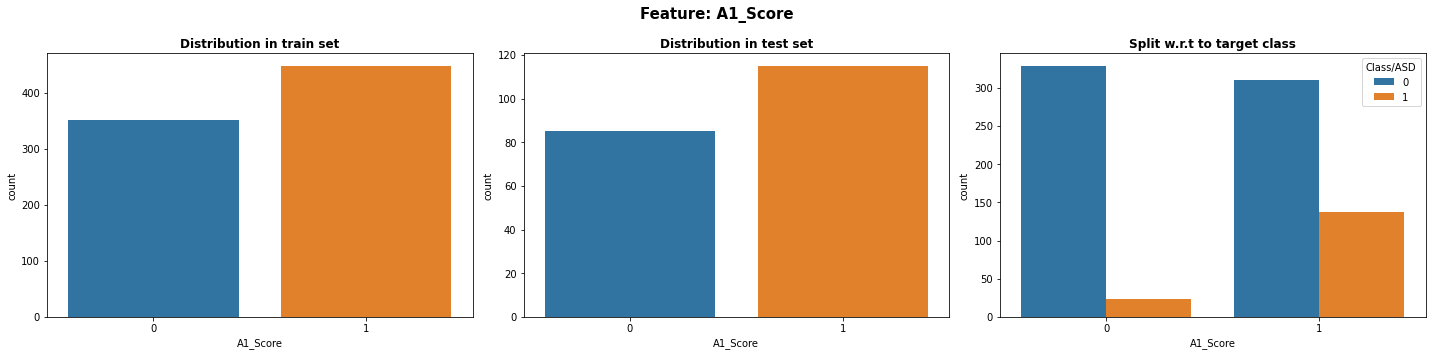

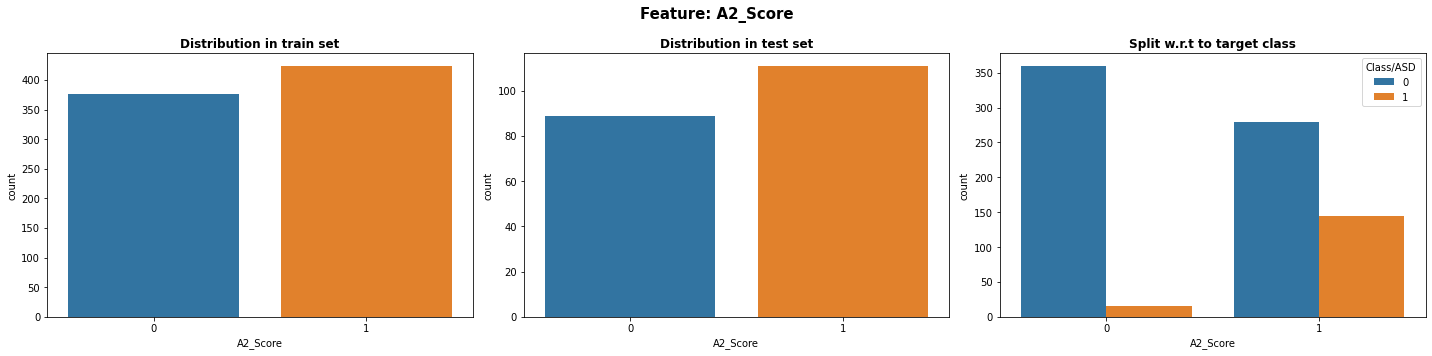

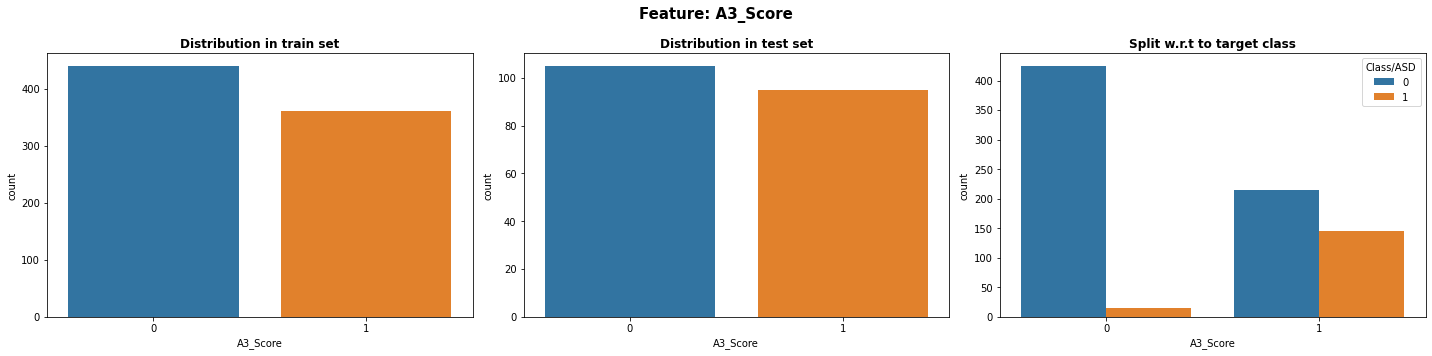

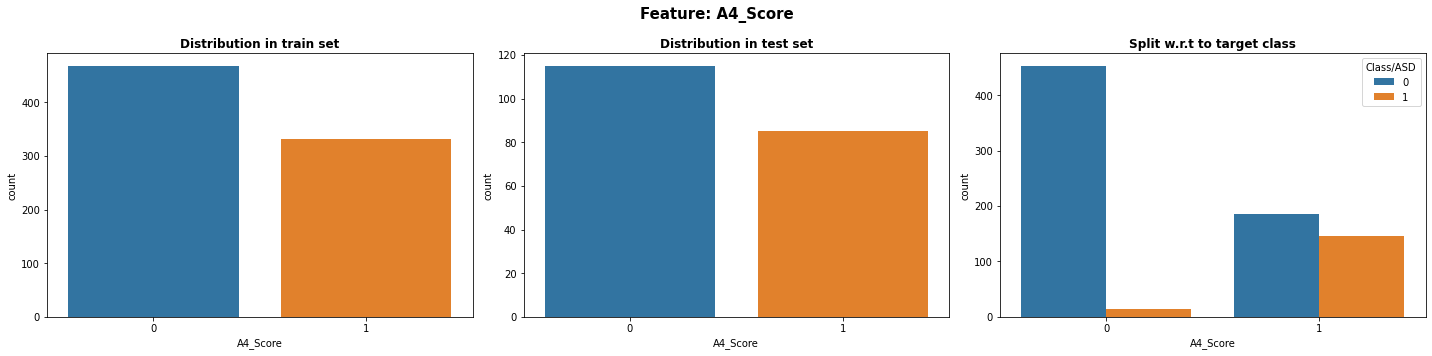

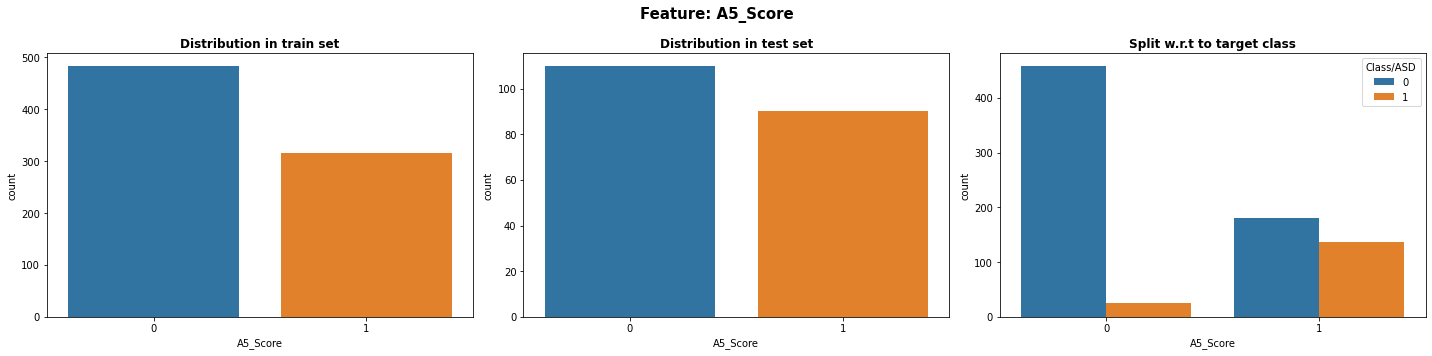

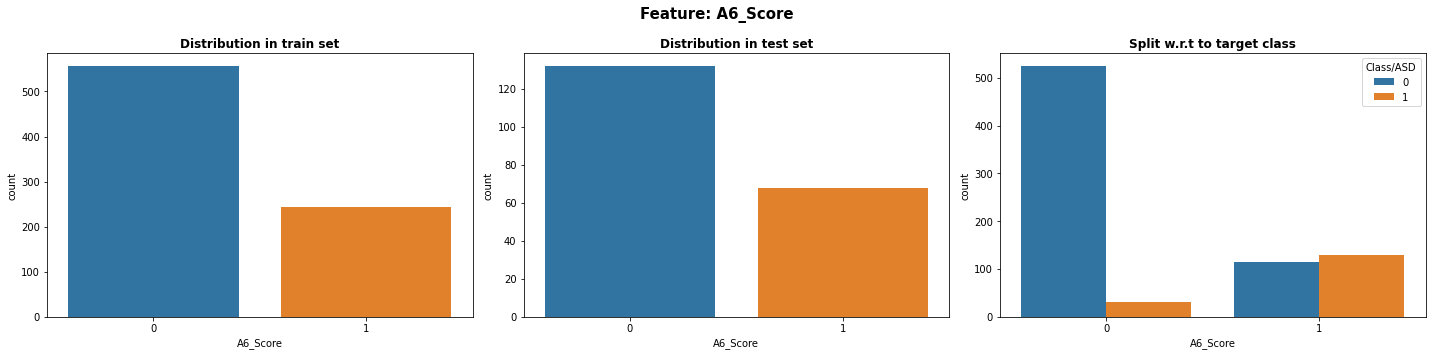

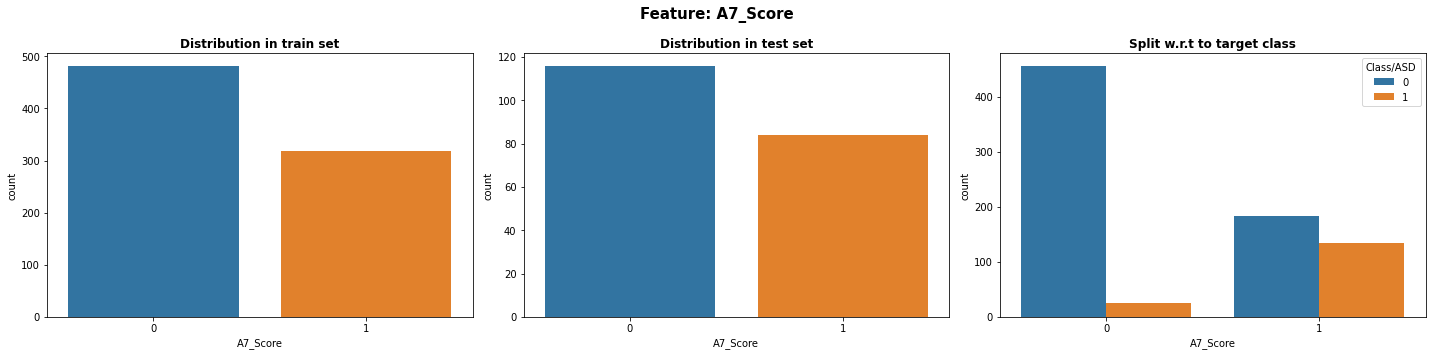

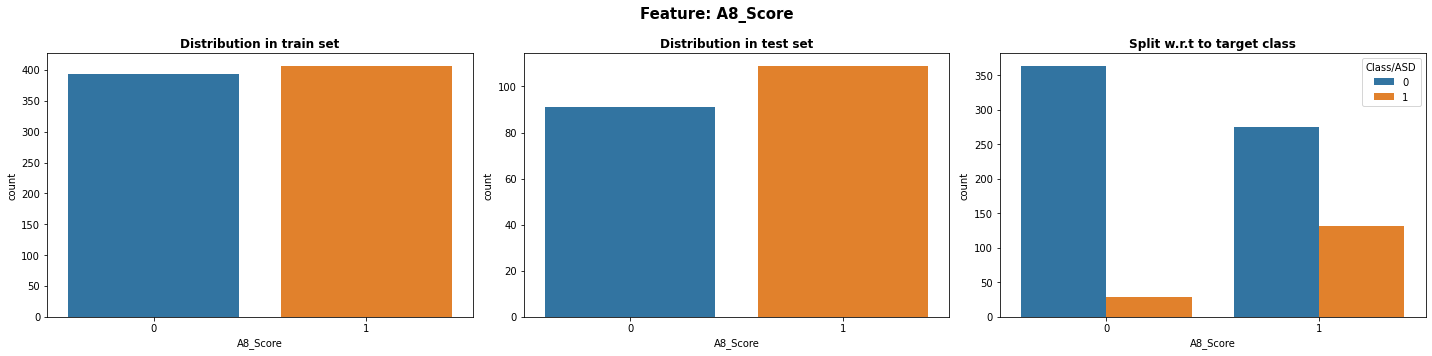

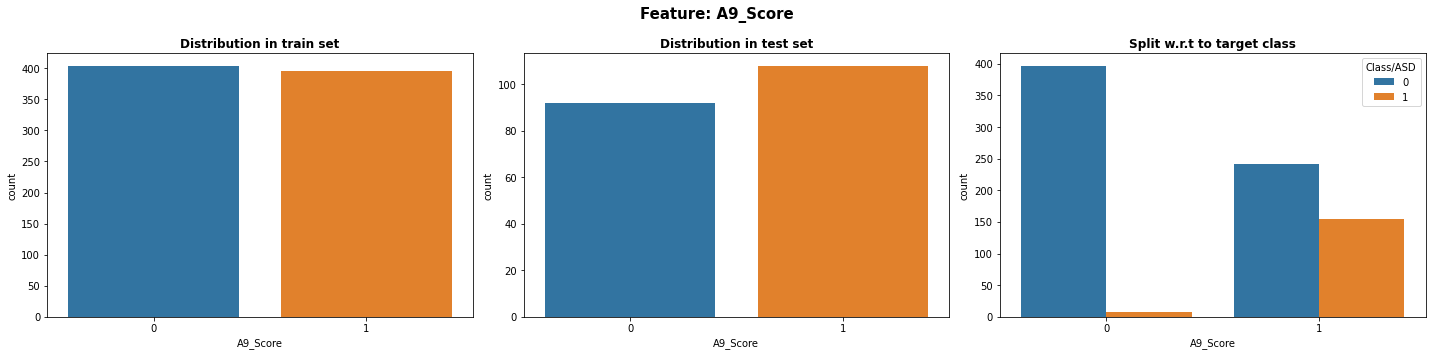

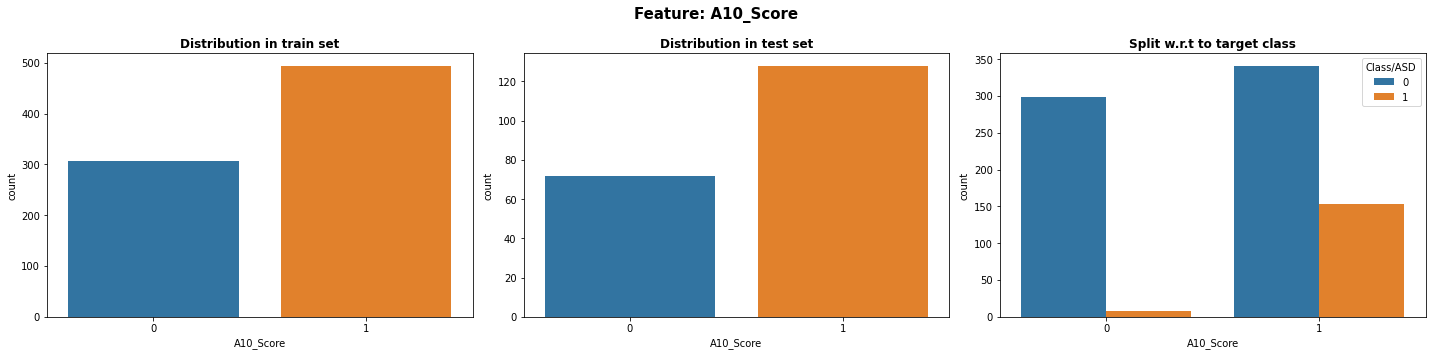

In [10]:
for i in range(1, 11):
    plot_cat(f'A{i}_Score')

1. Train and test dataset distributions are nearly identical for all scores except *A5*, *A8* and *A9*, where the difference is not significant.  
2. All the scores show significant splits - a score of 1 greatly increases the probability of positive class. So we can be sure that it is the score decided after the agree/disagree answer to a question. In a way, all our scores are now positive indicators. Also, **they can be treated as numerical features**. 
3. From our background knowledge of the AQ-10 test, we can create features based on the sum of A*_Scores (is >= 6 or not).

In [11]:
aq_scores = [f'A{i}_Score' for i in range(1, 11)]

train['AQ10_sum'] = train[aq_scores].sum(axis=1)
test['AQ10_sum'] = test[aq_scores].sum(axis=1)

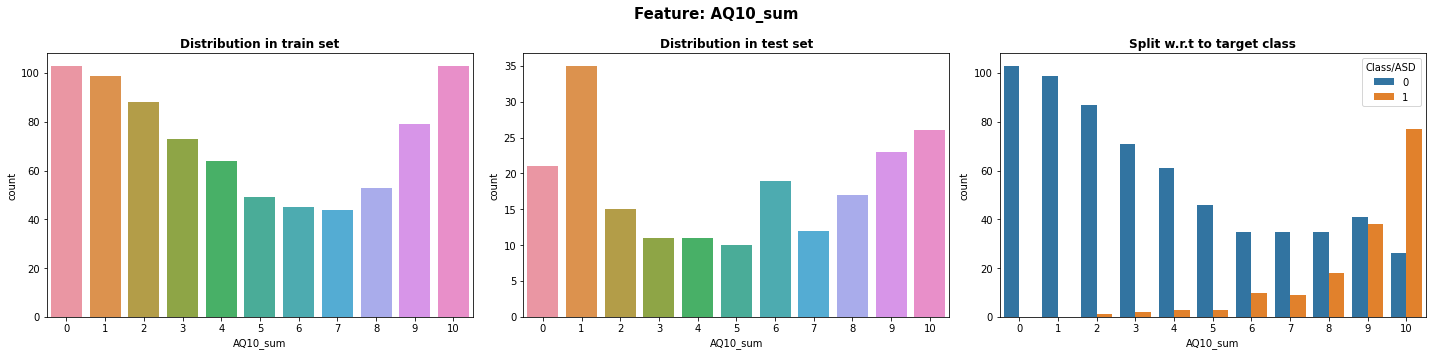

In [12]:
plot_cat('AQ10_sum')

We will treat this as a numerical feature during feature selection and modeling.

In [13]:
train['AQ10_6_or_above'] = (train['AQ10_sum'] > 5).astype('int')
test['AQ10_6_or_above'] = (test['AQ10_sum'] > 5).astype('int')

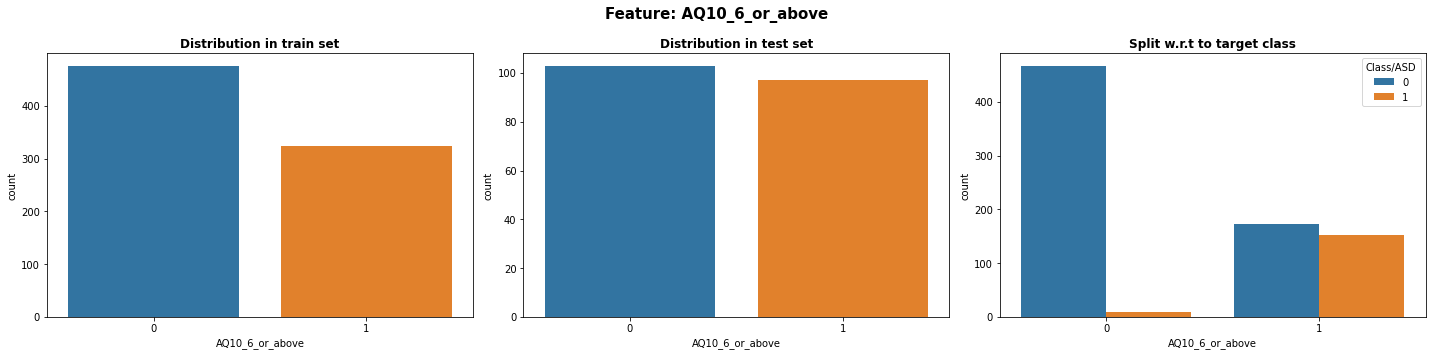

In [14]:
plot_cat('AQ10_6_or_above')

The features we created are definitely informative but we will need to check for redundance when we perform feature selection.

### gender

In [15]:
train['gender'].unique()

array(['f', 'm'], dtype=object)

In [16]:
train.replace(to_replace={'f': 0, 'm': 1}, inplace=True)
test.replace(to_replace={'f': 0, 'm': 1}, inplace=True)

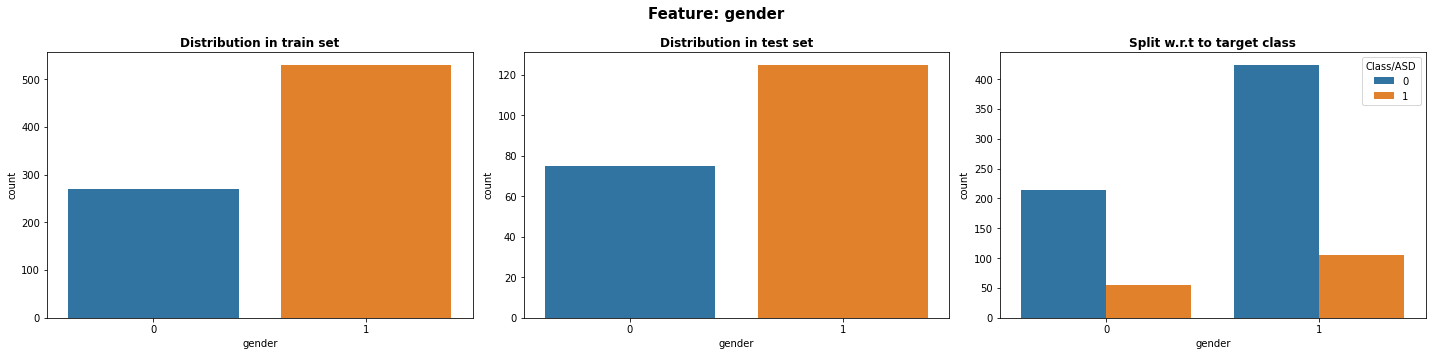

In [17]:
plot_cat('gender')

Distribution of target class within *gender*:

In [18]:
pd.DataFrame(train.groupby('gender')[TARGET].value_counts(normalize=True))

Class/ASD
gender Class/ASD           
0      0             0.7963
       1             0.2037
1      0             0.8000
       1             0.2000

Looks like *gender* may not be an informative feature. The proportion of diagnoses for males and females is the same.  

This is contrary to [what is observed in the medical community](https://www.cdc.gov/ncbddd/autism/data.html).

### ethnicity

In [19]:
train['ethnicity'].nunique(), test['ethnicity'].nunique()

(12, 11)

In [20]:
set(test['ethnicity'].unique()) - set(train['ethnicity'].unique())

set()

No unseen values in test set.

In [21]:
train['ethnicity'].value_counts(normalize=True)

White-European     0.3212
?                  0.2537
Middle Eastern     0.1212
Asian              0.0838
Black              0.0587
South Asian        0.0425
Pasifika           0.0400
Others             0.0362
Latino             0.0213
Hispanic           0.0112
Turkish            0.0063
others             0.0037
Name: ethnicity, dtype: float64

'?' is a missing value. We can fill the missing value with 'Others' since we do not know the ethnicity anyways. But all the missing values could also be 'White-European', which is the most frequent category.  
Handling the '?' value will end up changing the distribution since it accounts for 25% of the data.  

First, we can fix the typo between 'others' and 'Others'.

In [22]:
train['ethnicity'].replace(to_replace='others', value='Others', inplace=True)
test['ethnicity'].replace(to_replace='others', value='Others', inplace=True)

Distribution of target class within *ethnicity*:

In [23]:
pd.DataFrame(pd.crosstab(train['ethnicity'], train[TARGET])).transpose()

ethnicity,?,Asian,Black,Hispanic,Latino,Middle Eastern,Others,Pasifika,South Asian,Turkish,White-European
Class/ASD,,,,,,,,,,,
0,196,63,41,7,13,91,30,26,31,5,136
1,7,4,6,2,4,6,2,6,3,0,121


We can observe a clear distinction between 'White-European' and other categories. We can combine the other categories to create a new feature which records if the patient is 'White-European' or not.  
Before combining the other categories, we should check if the *ethnicity* distribution is the same in the test set as well.

In [24]:
test['ethnicity'].value_counts(normalize=True)

White-European     0.330
?                  0.270
Middle Eastern     0.135
Asian              0.085
South Asian        0.045
Pasifika           0.040
Others             0.035
Latino             0.020
Turkish            0.015
Black              0.015
Hispanic           0.010
Name: ethnicity, dtype: float64

Almost identical distributions. We can proceed with creating our new feature.

In [25]:
train['is_White_European'] = (train['ethnicity'] == 'White-European').astype(int)
test['is_White_European'] = (test['ethnicity'] == 'White-European').astype(int)

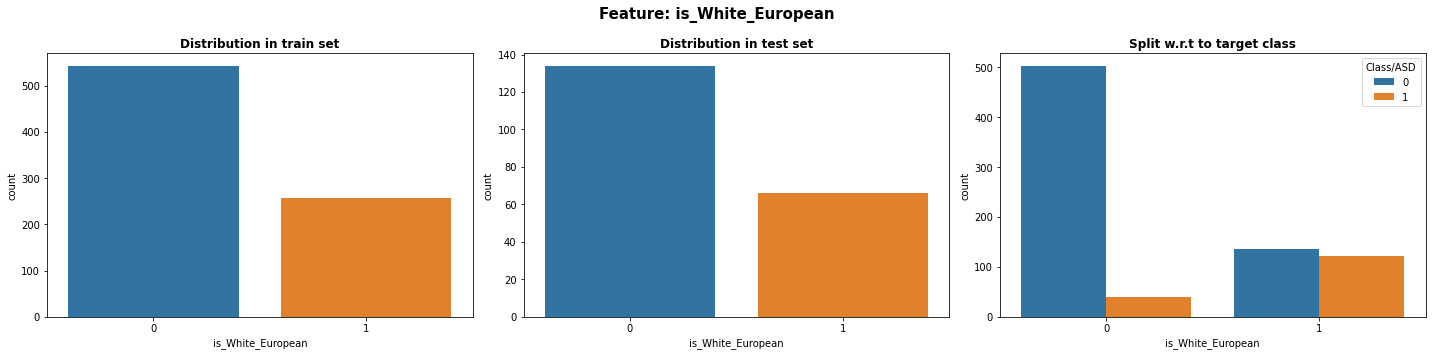

In [26]:
plot_cat('is_White_European')

In [27]:
pd.DataFrame(train.groupby('is_White_European')[TARGET].value_counts(normalize=True))

Class/ASD
is_White_European Class/ASD           
0                 0             0.9263
                  1             0.0737
1                 0             0.5292
                  1             0.4708

We have created an informative feature from *ethnicity*. 

### jaundice
(at the time of birth)

In [28]:
train['jaundice'].unique()

array(['no', 'yes'], dtype=object)

In [29]:
train['jaundice'].replace(to_replace={'no': 0, 'yes': 1}, inplace=True)
test['jaundice'].replace(to_replace={'no': 0, 'yes': 1}, inplace=True)

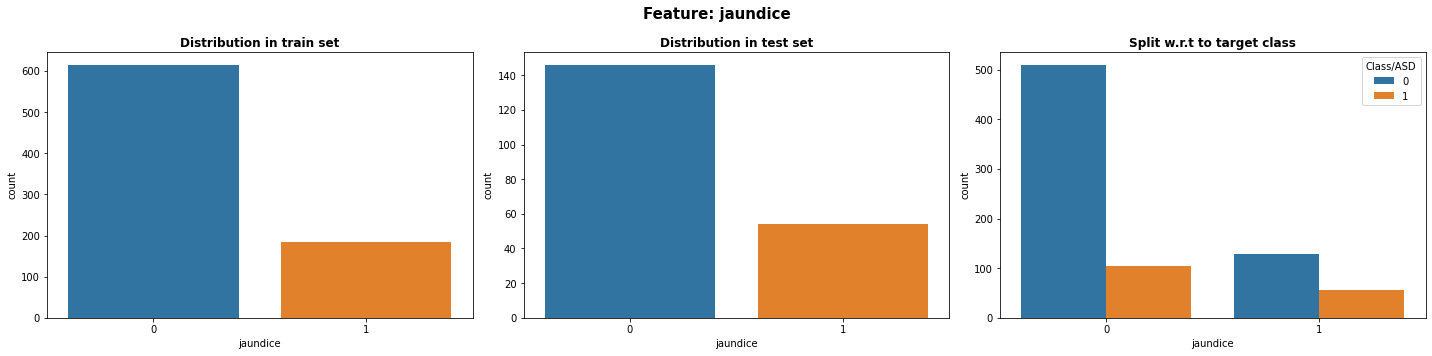

In [30]:
plot_cat('jaundice')

Distribution of target class within *jaundice*:

In [31]:
pd.DataFrame(train.groupby('jaundice')[TARGET].value_counts(normalize=True))

Class/ASD
jaundice Class/ASD           
0        0             0.8293
         1             0.1707
1        0             0.6973
         1             0.3027

There is a slight association that we can explore further during feature selection.

### austim -> autism_family
(Whether an immediate family member has been diagnosed with autism)

In [32]:
train.rename({'austim': 'autism_family'}, axis=1, inplace=True)
test.rename({'austim': 'autism_family'}, axis=1, inplace=True)

In [33]:
train['autism_family'].unique()

array(['no', 'yes'], dtype=object)

In [34]:
train['autism_family'].replace(to_replace={'no': 0, 'yes': 1}, inplace=True)
test['autism_family'].replace(to_replace={'no': 0, 'yes': 1}, inplace=True)

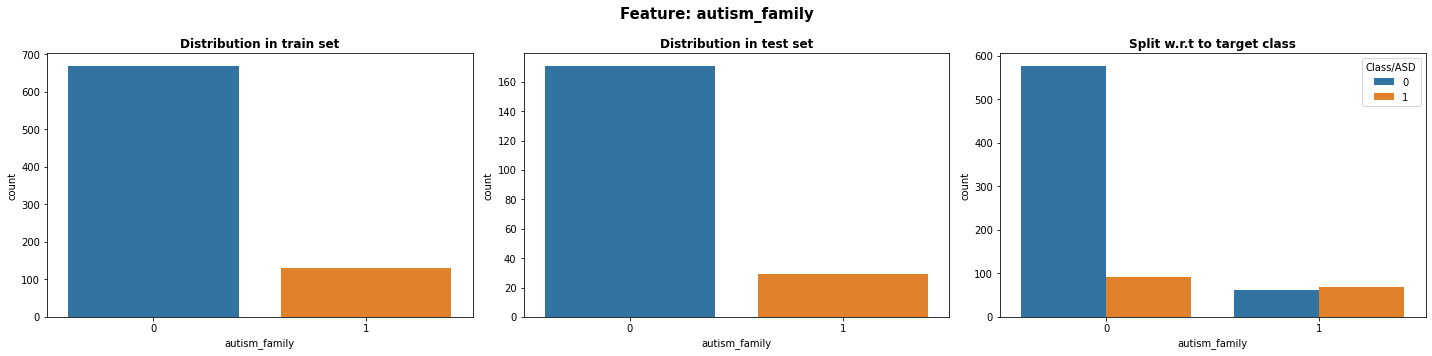

In [35]:
plot_cat('autism_family')

Distribution of target class within *autism_family*:

In [36]:
pd.DataFrame(train.groupby('autism_family')[TARGET].value_counts(normalize=True))

Class/ASD
autism_family Class/ASD           
0             0             0.8625
              1             0.1375
1             1             0.5267
              0             0.4733

A significant association between family history of autism and diagnosis.  
Not only do genetic factors directly affect chances of a positive diagnosis, but families with history of autism are also more likely to be aware of testing/treatment.

### contry_of_res -> country
(Country of residence of the patient)

In [37]:
train.rename({'contry_of_res': 'country'}, axis=1, inplace=True)
test.rename({'contry_of_res': 'country'}, axis=1, inplace=True)

In [38]:
train['country'].nunique(), test['country'].nunique()

(56, 35)

In [39]:
set(test['country'].unique()) - set(train['country'].unique())

{'Lebanon', 'Philippines', 'Uruguay'}

Three unseen values in test set.

In [40]:
pd.DataFrame(pd.crosstab(train['country'], train[TARGET])).transpose()

country,Afghanistan,AmericanSamoa,Angola,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bangladesh,Belgium,Bolivia,Brazil,Burundi,Canada,China,Cyprus,Czech Republic,Egypt,Ethiopia,France,Germany,Hong Kong,Iceland,India,Iran,Iraq,Ireland,Italy,Japan,Jordan,Kazakhstan,Malaysia,Mexico,Netherlands,New Zealand,Nicaragua,Niger,Oman,Pakistan,Romania,Russia,Saudi Arabia,Serbia,Sierra Leone,South Africa,Spain,Sri Lanka,Sweden,Tonga,Ukraine,United Arab Emirates,United Kingdom,United States,Viet Nam
Class/ASD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,19,4,1,1,2,2,30,17,2,5,1,1,2,11,0,21,4,1,1,1,2,7,3,1,3,105,7,4,7,5,1,52,7,5,4,18,77,4,2,0,2,1,7,3,3,1,6,8,16,2,1,2,40,39,65,3
1,3,0,0,0,2,2,7,1,2,1,0,0,1,1,1,9,0,1,0,0,1,3,0,0,0,3,1,0,2,1,0,3,3,1,0,2,1,0,1,2,2,0,0,1,0,0,0,2,1,0,0,1,0,28,69,2


Looking at the target class distributions for the various countries, we can see that it is similar to the information captured by the *ethnicity* column. Predominantly white populations such as US and UK have about a 50-50 split of diagnoses, while the other countries have very low positive rates.  
Moreover, ethnicity is better at representing genetic factors compared to country of residence. A person of Indian or Russian origin could be living in the United States. But the chances of ASD would be dependent on their Indian/Russian family trees as opposed to their residence in the United States.  
**On the basis of these two arguments, we will drop *country* from our features.**

### used_app_before
(Whether the patient has undergone a screening test before)

In [41]:
train['used_app_before'].unique()

array(['no', 'yes'], dtype=object)

In [42]:
train['used_app_before'].replace(to_replace={'no': 0, 'yes': 1}, inplace=True)
test['used_app_before'].replace(to_replace={'no': 0, 'yes': 1}, inplace=True)

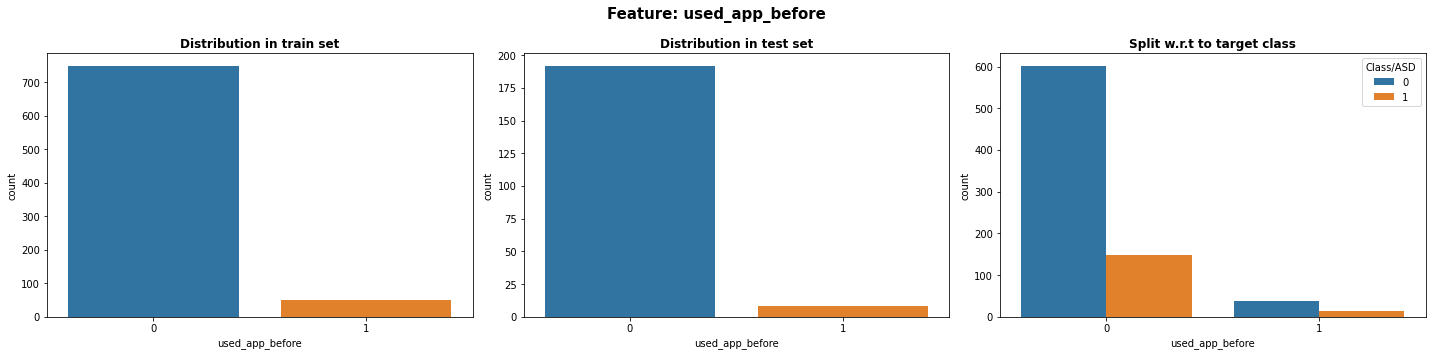

In [43]:
plot_cat('used_app_before')

In [44]:
pd.DataFrame(train.groupby('used_app_before')[TARGET].value_counts(normalize=True))

Class/ASD
used_app_before Class/ASD           
0               0             0.8027
                1             0.1973
1               0             0.7400
                1             0.2600

Just like *gender*, this feature does not appear to be informative. It is also heavily imbalanced, with no scope for adjustments.

### relation
(Relation of patient who completed the test)

In [45]:
train['relation'].unique(), test['relation'].unique()

(array(['Self', 'Relative', 'Parent', '?', 'Others',
        'Health care professional'], dtype=object),
 array(['Self', 'Parent', '?', 'Relative', 'Others',
        'Health care professional'], dtype=object))

'?' is a missing value which we can fill only after some investigation.

In [46]:
train['relation'].value_counts()

Self                        709
?                            40
Parent                       29
Relative                     18
Others                        2
Health care professional      2
Name: relation, dtype: int64

Heavily imbalanced column.

In [47]:
pd.DataFrame(pd.crosstab(train['relation'], train[TARGET]))

Class/ASD,0,1
relation,,
?,39,1
Health care professional,1,1
Others,2,0
Parent,21,8
Relative,14,4
Self,562,147


In [48]:
relation_mapping = {
    'Self': 2, 
    'Parent': 1, 'Relative': 1, 
    'Others': 0, '?': 0, 'Health care professional': 0
}

train['filled_by_self'] = (train['relation'] == 'Self').astype(int)
test['filled_by_self'] = (test['relation'] == 'Self').astype(int)

train['relation'].replace(to_replace=relation_mapping, inplace=True)
test['relation'].replace(to_replace=relation_mapping, inplace=True)

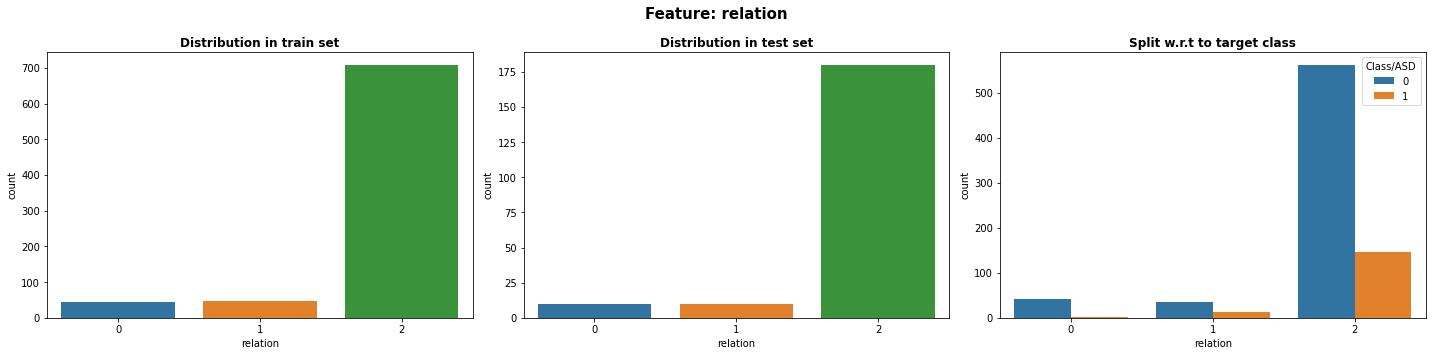

In [49]:
plot_cat('relation')

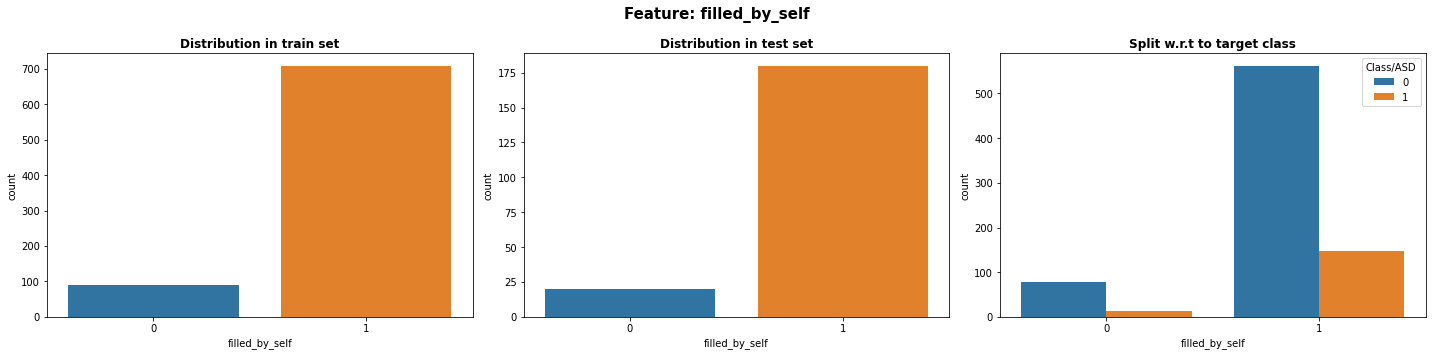

In [50]:
plot_cat('filled_by_self')

Even after logical reclassification, the feature is still heavily imbalanced. We will need support from statistical tests if we are to include it as a feature.  

**Moving on to the continuous features.**

In [51]:
def plot_cont(feature):
    """Display side-by-side kdeplots for a continuous feature.
    
    The following plots are displayed:
    1. Distribution in train set
    2. Distribution in test set
    3. Split distribution in train set w.r.t target classes
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
    plt.suptitle(f'Feature: {feature}', fontsize=15, fontweight='bold')
    
    sns.kdeplot(x=feature, data=train, ax=ax1)
    ax1.set_title('Distribution in train set', fontweight='bold')
    sns.kdeplot(x=feature, data=test, ax=ax2)
    ax2.set_title('Distribution in test set', fontweight='bold')
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax3)
    ax3.set_title('Split w.r.t to target class', fontweight='bold')
    
    fig.set_tight_layout(tight=True)
    plt.show()

### age

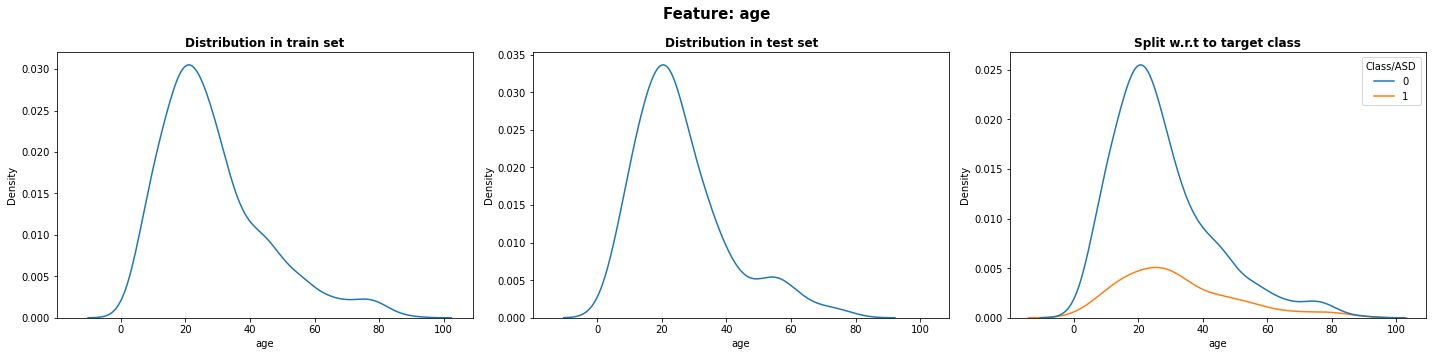

In [52]:
plot_cont('age')

Similar distributions in both datasets. No visual split based on target.

We can also create a categorical feature ***age_group***, based on *age*, by binning/bucketing the values logically.

In [53]:
def create_age_group(age):
    """Determine age group and return an integer indicating the category."""
    if age < 13: 
        return 0 #child
    elif age < 21: 
        return 1 #adolescent
    elif age < 40: 
        return 2 #adult
    elif age < 60: 
        return 3 #middle-aged
    else: 
        return 4 #elderly

In [54]:
train['age_group'] = train['age'].apply(lambda x: create_age_group(x))
test['age_group'] = test['age'].apply(lambda x: create_age_group(x))

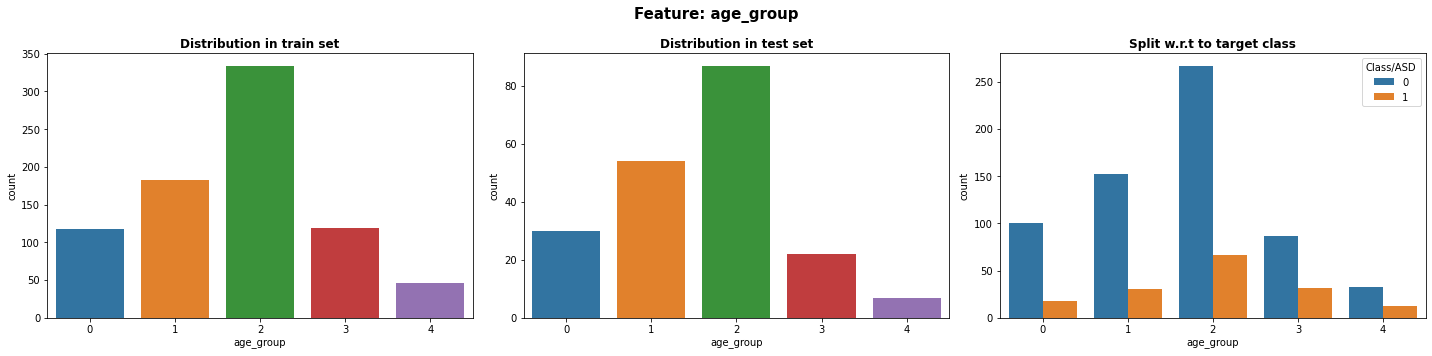

In [55]:
plot_cat('age_group')

### result
(Score for AQ1-10 screening test)

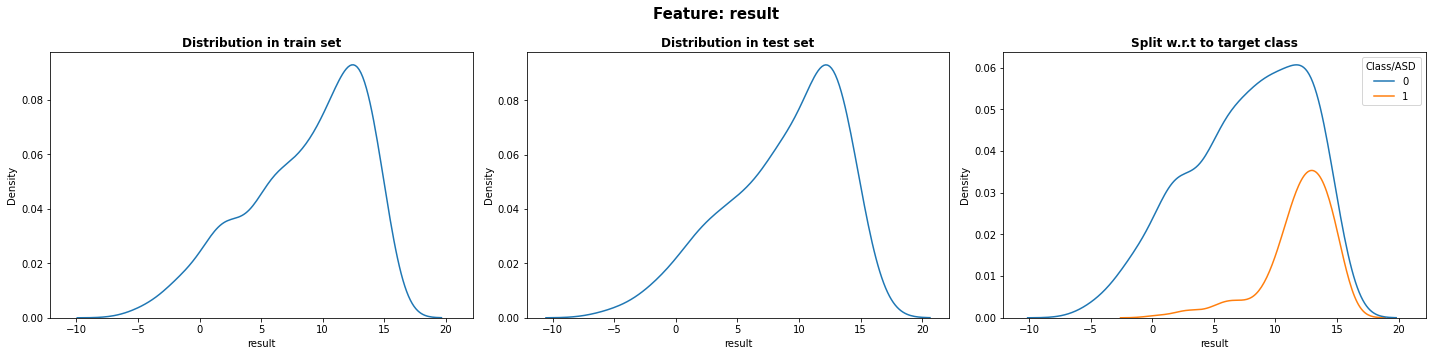

In [56]:
plot_cont('result')

Obviously this is not a cumulative score from the AQ10 test as we saw earlier, but based off of some other formula.  

Similar distributions in both datasets. The splits have peaks in the same range but at lower values the difference is visibly significant.

# Feature selection

In [57]:
features = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 
            'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 
            'AQ10_sum', 'AQ10_6_or_above', 'result', 'age', 'age_group',
            'gender', 'autism_family', 'is_White_European', 'jaundice', 
            'used_app_before', 'relation', 'filled_by_self']

cat_features = ['AQ10_6_or_above', 'age_group', 'gender', 
                'autism_family', 'is_White_European', 'jaundice', 
                'used_app_before', 'relation', 'filled_by_self']

num_features = [f for f in features if f not in cat_features]

### Chi-square test of independence (categorical feature - categorical target)
(Interpretation:  
 Null hypothesis - 'The feature and target are independent'.  
 If p-value is more than 0.05, we fail to reject null hypothesis -> they are actually independent
 
 Also, higher test statistic -> higher dependence)

In [58]:
chi2_test = chi2(train[cat_features], train[TARGET])

pd.DataFrame(
    data={'chi2-statistic': chi2_test[0], 
          'p-value': chi2_test[1]}, 
    index=cat_features
).transpose()

,AQ10_6_or_above,age_group,gender,autism_family,is_White_European,jaundice,used_app_before,relation,filled_by_self
chi2-statistic,1.4464e+02,4.8256,0.0052,8.6326e+01,1.1618e+02,11.8455,1.0736,0.5297,0.1633
p-value,2.5704e-33,0.0280,0.9428,1.5261e-20,4.3471e-27,0.0006,0.3001,0.4667,0.6862


***age_group*, *gender*, *used_app_before*, *relation* and *filled_by_self* are rejected by the chi-square test.**  
This also backs up our understanding from the visualizations.

In [59]:
#scores are technically numerical but we only have two possible values 
#so we can also treat them as categorical features here for the chi2 test
chi2_test = chi2(train[aq_scores], train[TARGET])

pd.DataFrame(
    data={'chi2-statistic': chi2_test[0], 
          'p-value': chi2_test[1]}, 
    index=aq_scores
).transpose()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
chi2-statistic,3.1780e+01,5.2240e+01,9.3479e+01,1.1749e+02,1.0321e+02,1.6424e+02,9.8622e+01,3.8352e+01,8.6735e+01,3.6155e+01
p-value,1.7264e-08,4.9127e-13,4.1044e-22,2.2422e-27,3.0211e-24,1.3426e-37,3.0562e-23,5.9082e-10,1.2408e-20,1.8220e-09


**As expected, target class is highly dependent on all the A*_scores.**

### Correlation (continuous feature - continuous/binary-categorical target)

In [60]:
train[['AQ10_sum', 'age', 'result', TARGET]].corr()

,AQ10_sum,age,result,Class/ASD
AQ10_sum,1.0000,0.1209,0.5147,0.5907
age,0.1209,1.0000,-0.2036,0.1099
result,0.5147,-0.2036,1.0000,0.3519
Class/ASD,0.5907,0.1099,0.3519,1.0000


A moderate positive relationship with the target for *AQ10_sum*; weak positive relationship for *age* and *result*.  

There is also a moderate positive relationship between *result* and *AQ10_sum* which means they are neither contradictory nor redundant.

### ANOVA F-test (continuous feature - categorical target)

(p-value interpretation same as Chi-square test)

In [61]:
anova_test = f_classif(train[num_features], train[TARGET])

pd.DataFrame(
    data={'f-statistic': anova_test[0], 
          'p-value': anova_test[1]}, 
    index=num_features
).transpose()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,AQ10_sum,result,age
f-statistic,7.9198e+01,1.2876e+02,2.1527e+02,2.6749e+02,2.1628e+02,3.3369e+02,2.0528e+02,8.6295e+01,2.1816e+02,1.0692e+02,4.2770e+02,1.1279e+02,9.7487
p-value,3.7235e-18,9.0248e-28,2.5086e-43,4.5360e-52,1.6851e-43,1.5015e-62,1.3328e-41,1.4389e-19,8.0212e-44,1.3249e-23,2.0555e-76,9.8126e-25,0.0019


All the numerical features satisfy the p-value threshold.  
*age* is the weakest indicator among numerical features by a large margin.

### Mutual Information

1. [Condensed explanation](https://quantdare.com/what-is-mutual-information/)
2. [Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

In [62]:
cat_mask = [(f in cat_features) for f in features] #boolean mask for discrete features

mi_scores = mutual_info_classif(train[features], train[TARGET], 
                                discrete_features=cat_mask, 
                                random_state=SEED)

mi_score_percent = mi_scores / sum(mi_scores) * 100

pd.DataFrame(
    data={'mi_score': mi_scores,
          'mi_score_percent': mi_score_percent}, 
    index=features
).transpose()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,AQ10_sum,AQ10_6_or_above,result,age,age_group,gender,autism_family,is_White_European,jaundice,used_app_before,relation,filled_by_self
mi_score,0.0725,0.0833,0.1060,0.1362,0.1244,0.1397,0.1048,0.0650,0.1367,0.0621,0.2057,0.1664,0.0889,0.0113,0.0050,9.5261e-06,0.0540,0.1015,0.0090,0.0007,0.0062,0.0009
mi_score_percent,4.3150,4.9568,6.3071,8.1063,7.4041,8.3140,6.2355,3.8688,8.1339,3.6959,12.2413,9.9040,5.2902,0.6731,0.2959,5.6701e-04,3.2141,6.0404,0.5351,0.0401,0.3714,0.0565


* *gender*, *used_app_before* and *filled_by_self* have very low MI scores, which matches our results from previous statistical tests. They are candidates for rejection here too.
* *age*, *age_group*, *jaundice* and *relation* have low scores in the same range. We expected *jaundice* to be much more informative than *relation*, judging from our previous statistical tests and visualizations.
* The A*_Score features we created turned out to be the most informative features.

### Feature sets

In [63]:
rejected_features = ['gender', 'used_app_before', 'filled_by_self']

selected_features = [f for f in features if f not in rejected_features]
best_features = [f for f in selected_features if f not in ('age', 'age_group', 'relation', 'jaundice')]

# Baseline

### Data preparation

In [64]:
target = train[TARGET]
test_index = test.ID

train = train[features]
test = test[features]

num_features = ['AQ10_sum', 'result', 'age']
cat_features = [f for f in features if f not in num_features]

train[cat_features] = train[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

gc.collect()

9013

In [65]:
xtrain, xval, ytrain, yval = train_test_split(
    train, target, 
    test_size=0.2,
    stratify=target, 
    shuffle=True, 
    random_state=SEED)

In [66]:
def create_model():
    """Create preprocessing and modeling pipeline, return a Pipeline instance."""
    
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
    ])

    numerical_pipeline = Pipeline([
        ('standardize', RobustScaler()),
        ('normalize', MinMaxScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('cat_preprocessor', categorical_pipeline, make_column_selector(dtype_include='category')),
        ('num_preprocessor', numerical_pipeline, make_column_selector(dtype_include='number'))
    ])

    model = Pipeline([
        ('preprocessing', preprocessor),
        ('modeling', LogisticRegression(random_state=SEED, solver='liblinear'))
    ])
    
    return model

### 1. All features

In [67]:
model1 = create_model()
model1.fit(xtrain, ytrain)

val_probs1 = model1.predict_proba(xval)[:, 1] #probability of class = 1
val_preds1 = model1.predict(xval)

print(f'AUC = {roc_auc_score(yval, val_probs1):.4f}')
print('Classification report:')
print(classification_report(yval, val_preds1, target_names=['class 0', 'class 1']))

AUC = 0.8892
Classification report:
              precision    recall  f1-score   support

     class 0       0.90      0.90      0.90       128
     class 1       0.59      0.59      0.59        32

    accuracy                           0.84       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.84      0.84      0.84       160



### 2. Selected features only

In [68]:
model2 = create_model()
model2.fit(xtrain[selected_features], ytrain)

val_probs2 = model2.predict_proba(xval[selected_features])[:, 1]
val_preds2 = model2.predict(xval[selected_features])

print(f'AUC = {roc_auc_score(yval, val_probs2):.4f}')
print('Classification report:')
print(classification_report(yval, val_preds2, target_names=['class 0', 'class 1']))

AUC = 0.8904
Classification report:
              precision    recall  f1-score   support

     class 0       0.90      0.90      0.90       128
     class 1       0.59      0.59      0.59        32

    accuracy                           0.84       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.84      0.84      0.84       160



### 3. Best features only

In [69]:
model3 = create_model()
model3.fit(xtrain[best_features], ytrain)

val_probs2 = model3.predict_proba(xval[best_features])[:, 1]
val_preds2 = model3.predict(xval[best_features])

print(f'AUC = {roc_auc_score(yval, val_probs2):.4f}')
print('Classification report:')
print(classification_report(yval, val_preds2, target_names=['class 0', 'class 1']))

AUC = 0.8960
Classification report:
              precision    recall  f1-score   support

     class 0       0.90      0.90      0.90       128
     class 1       0.59      0.59      0.59        32

    accuracy                           0.84       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.84      0.84      0.84       160



**Our performance is improving with the quality of our feature sets.**  
* AUC is increasing which means the model is getting more (correctly) confident in its predictions. However, our accuracy remains the same which means the class-imbalance is restricting the model from reclassifying any more samples correctly, There is scope for including resampling in the modeling pipeline.
* Here we have used only Logistic Regression as a baseline, but there may be greater improvement for more complex models such as gradient-boosting or neural networks.  

# Generating submission file

In [70]:
#using our best model
predictions = model3.predict_proba(test[best_features])[:, 1]

In [71]:
submission = pd.DataFrame({
    'ID': test_index,
    'Class/ASD': predictions})

submission.to_csv('submission.csv', index=False)

In [72]:
!head submission.csv

ID,Class/ASD
1,0.14517626994086144
2,0.01741011355399775
3,0.39792937286900915
4,0.014352928747451657
5,0.034102253499992206
6,0.0225750507470272
7,0.4250504957647749
8,0.1877861095938832
9,0.012872818499226014


**Would appreciate any feedback about the content as well as the presentation. Thank you!**